In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import shap

import lab.functions as func
from etl.esios.provider import ESIOSDataProvider

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

SEED=0
np.random.seed(SEED)
save_path = "lab/models/hourly/"

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
forecasting_horizon = 168
fh = list(range(1, forecasting_horizon+1))

nb_windows = 20
step_size = 25

In [5]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']


## Postpandemic

In [6]:
best_model = GradientBoostingRegressor(random_state=0)

In [7]:
esios_df = esios_provider.get_all_series(freq="H", start_index="2022-10-01 00:00", end_index="2023-03-31 23:59")

contamination = 0.01
esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

esios_spot = esios_df["PRECIO_MERCADO_SPOT_DIARIO"]
X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
lags = [1, 2, 12, 23, 24, 36, 71, 72, 167, 168]
date_features = ["hour", "day", "day_of_week"]

### 1 hour forecast horizon

In [8]:
shap_values_first_postpandemic = func.predictors_influence_study(esios_spot, X, best_model, lags, date_features, forecasting_horizon, version="first", seed=SEED)

Permutation explainer: 606it [00:40, 11.85it/s]                         


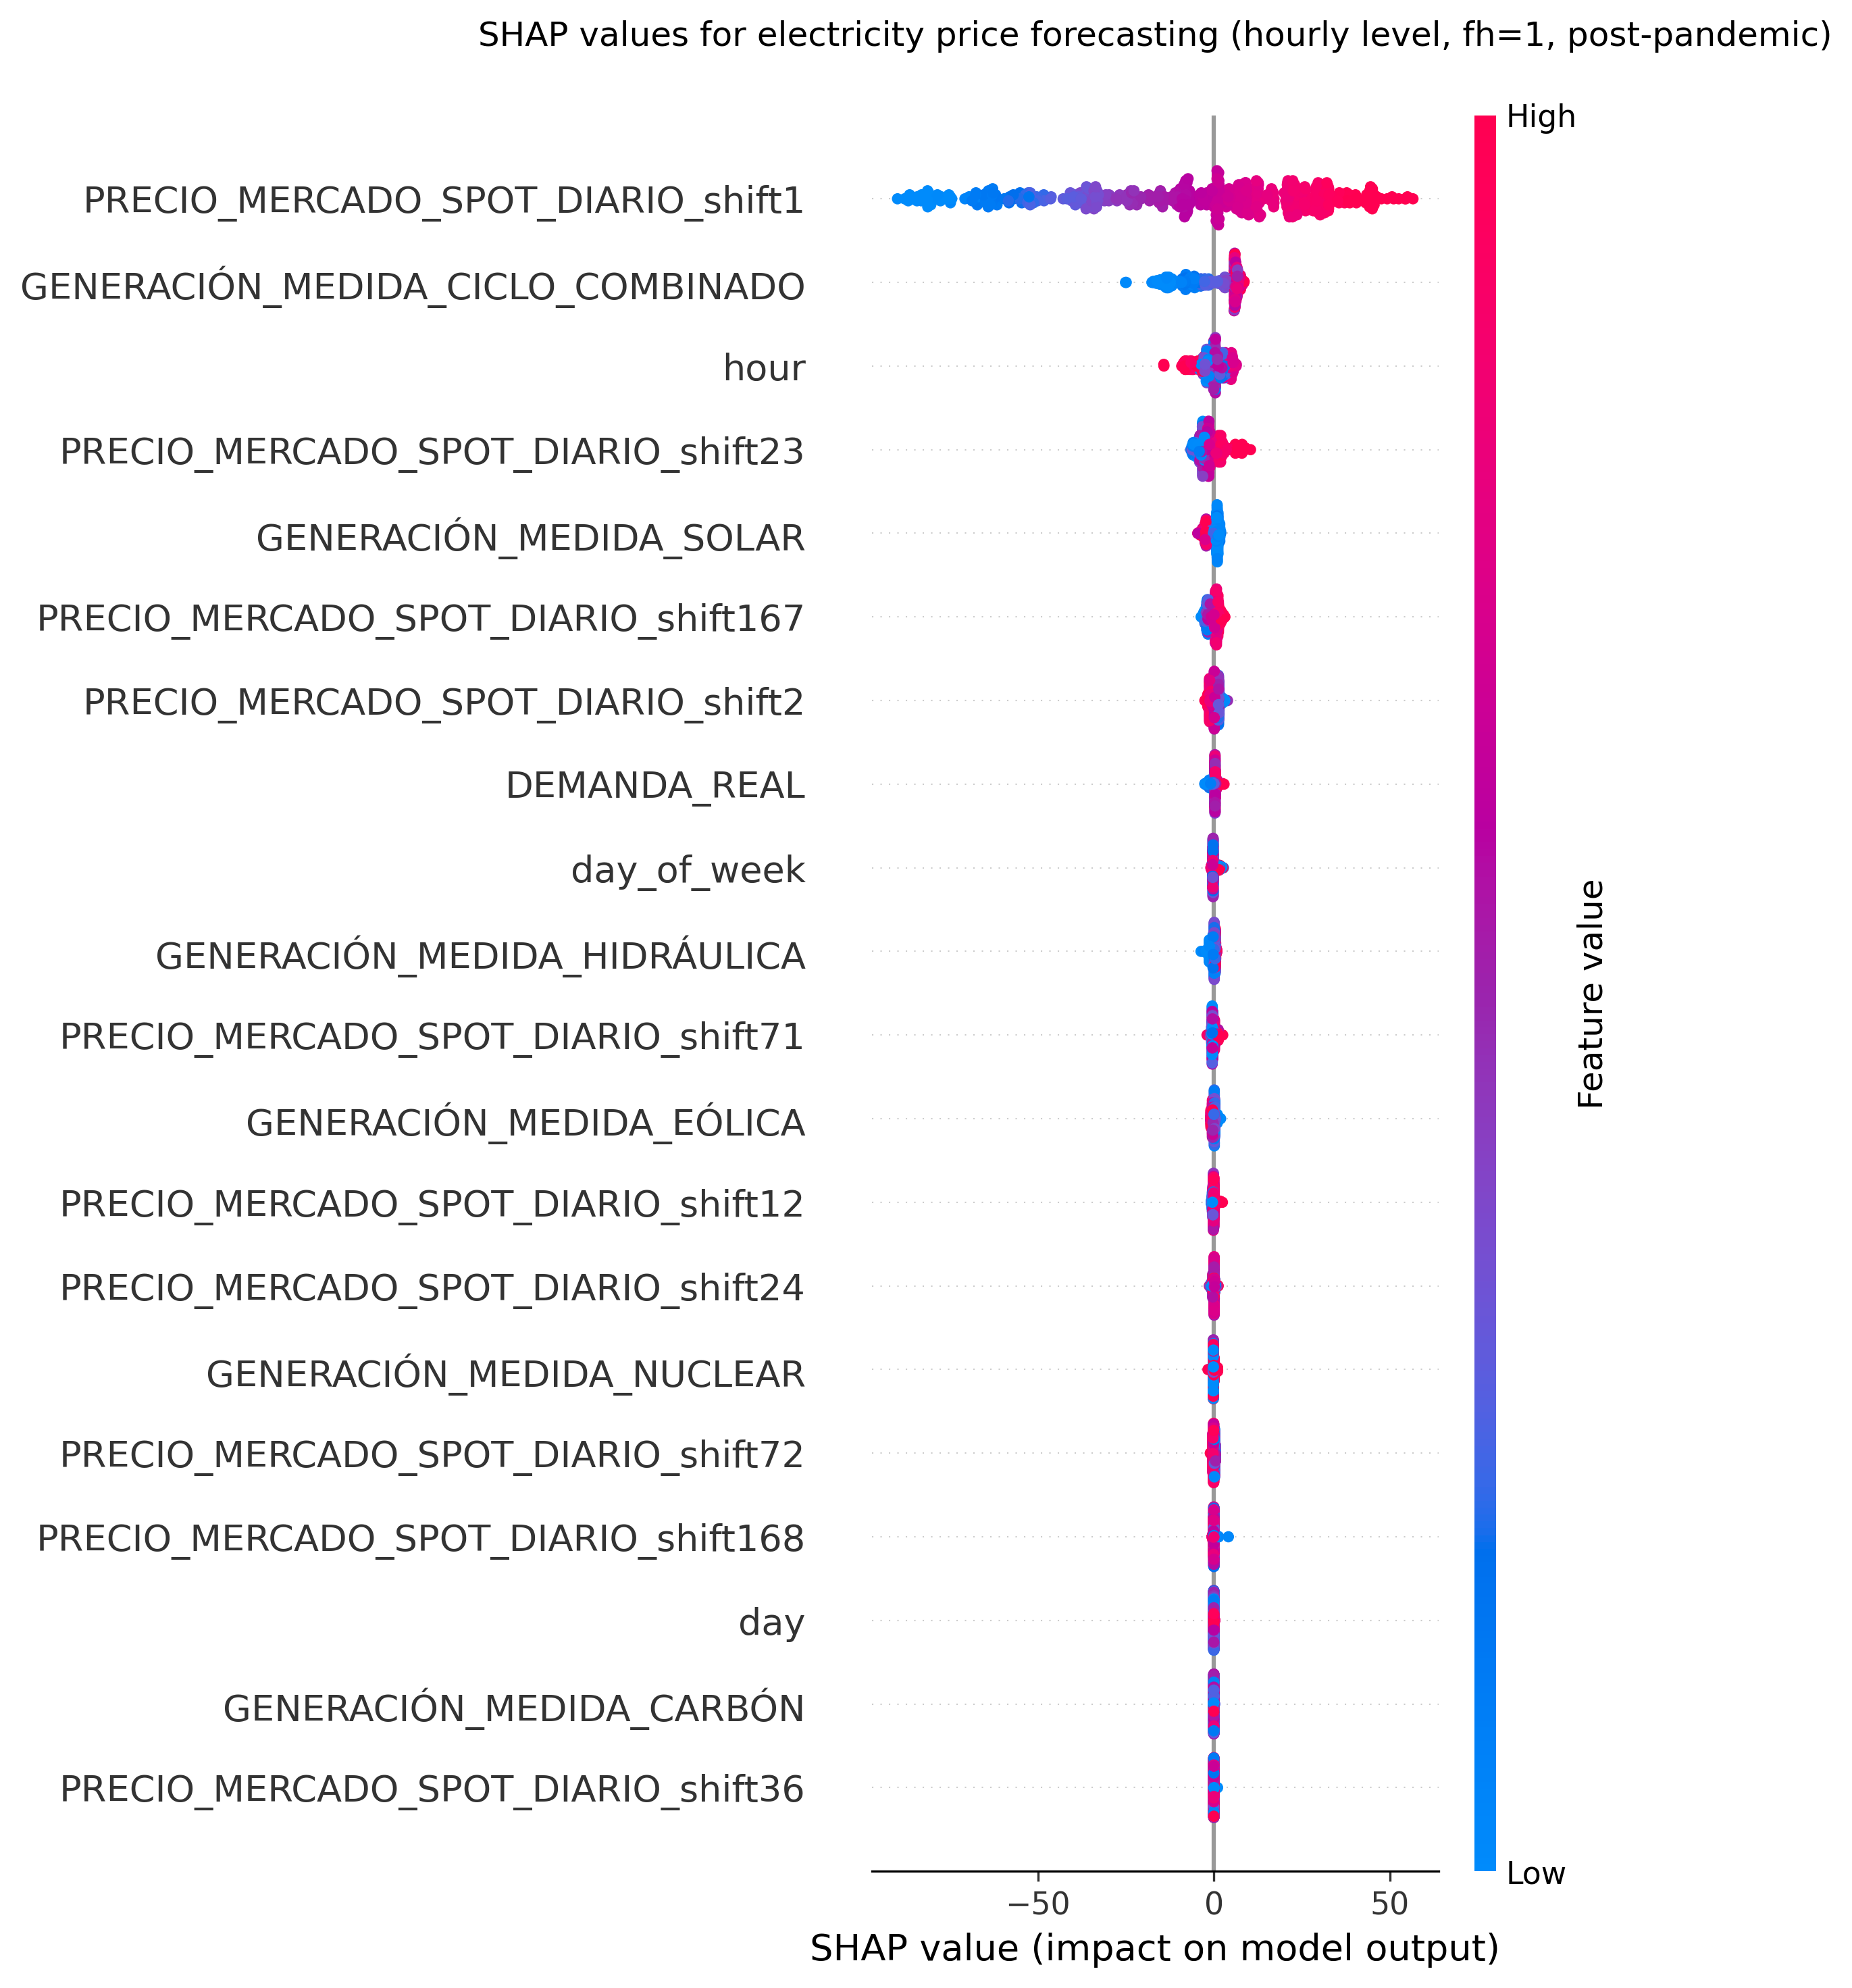

In [9]:
shap.summary_plot(shap_values_first_postpandemic, show=False)
plt.title("SHAP values for electricity price forecasting (hourly level, fh=1, post-pandemic)", y=1.03)
plt.show()

### 168 hours forecast horizon

In [10]:
shap_values_last_postpandemic = func.predictors_influence_study(esios_spot, X, best_model, lags, date_features, forecasting_horizon, version="last", seed=SEED)

Permutation explainer: 606it [00:37, 11.58it/s]                         


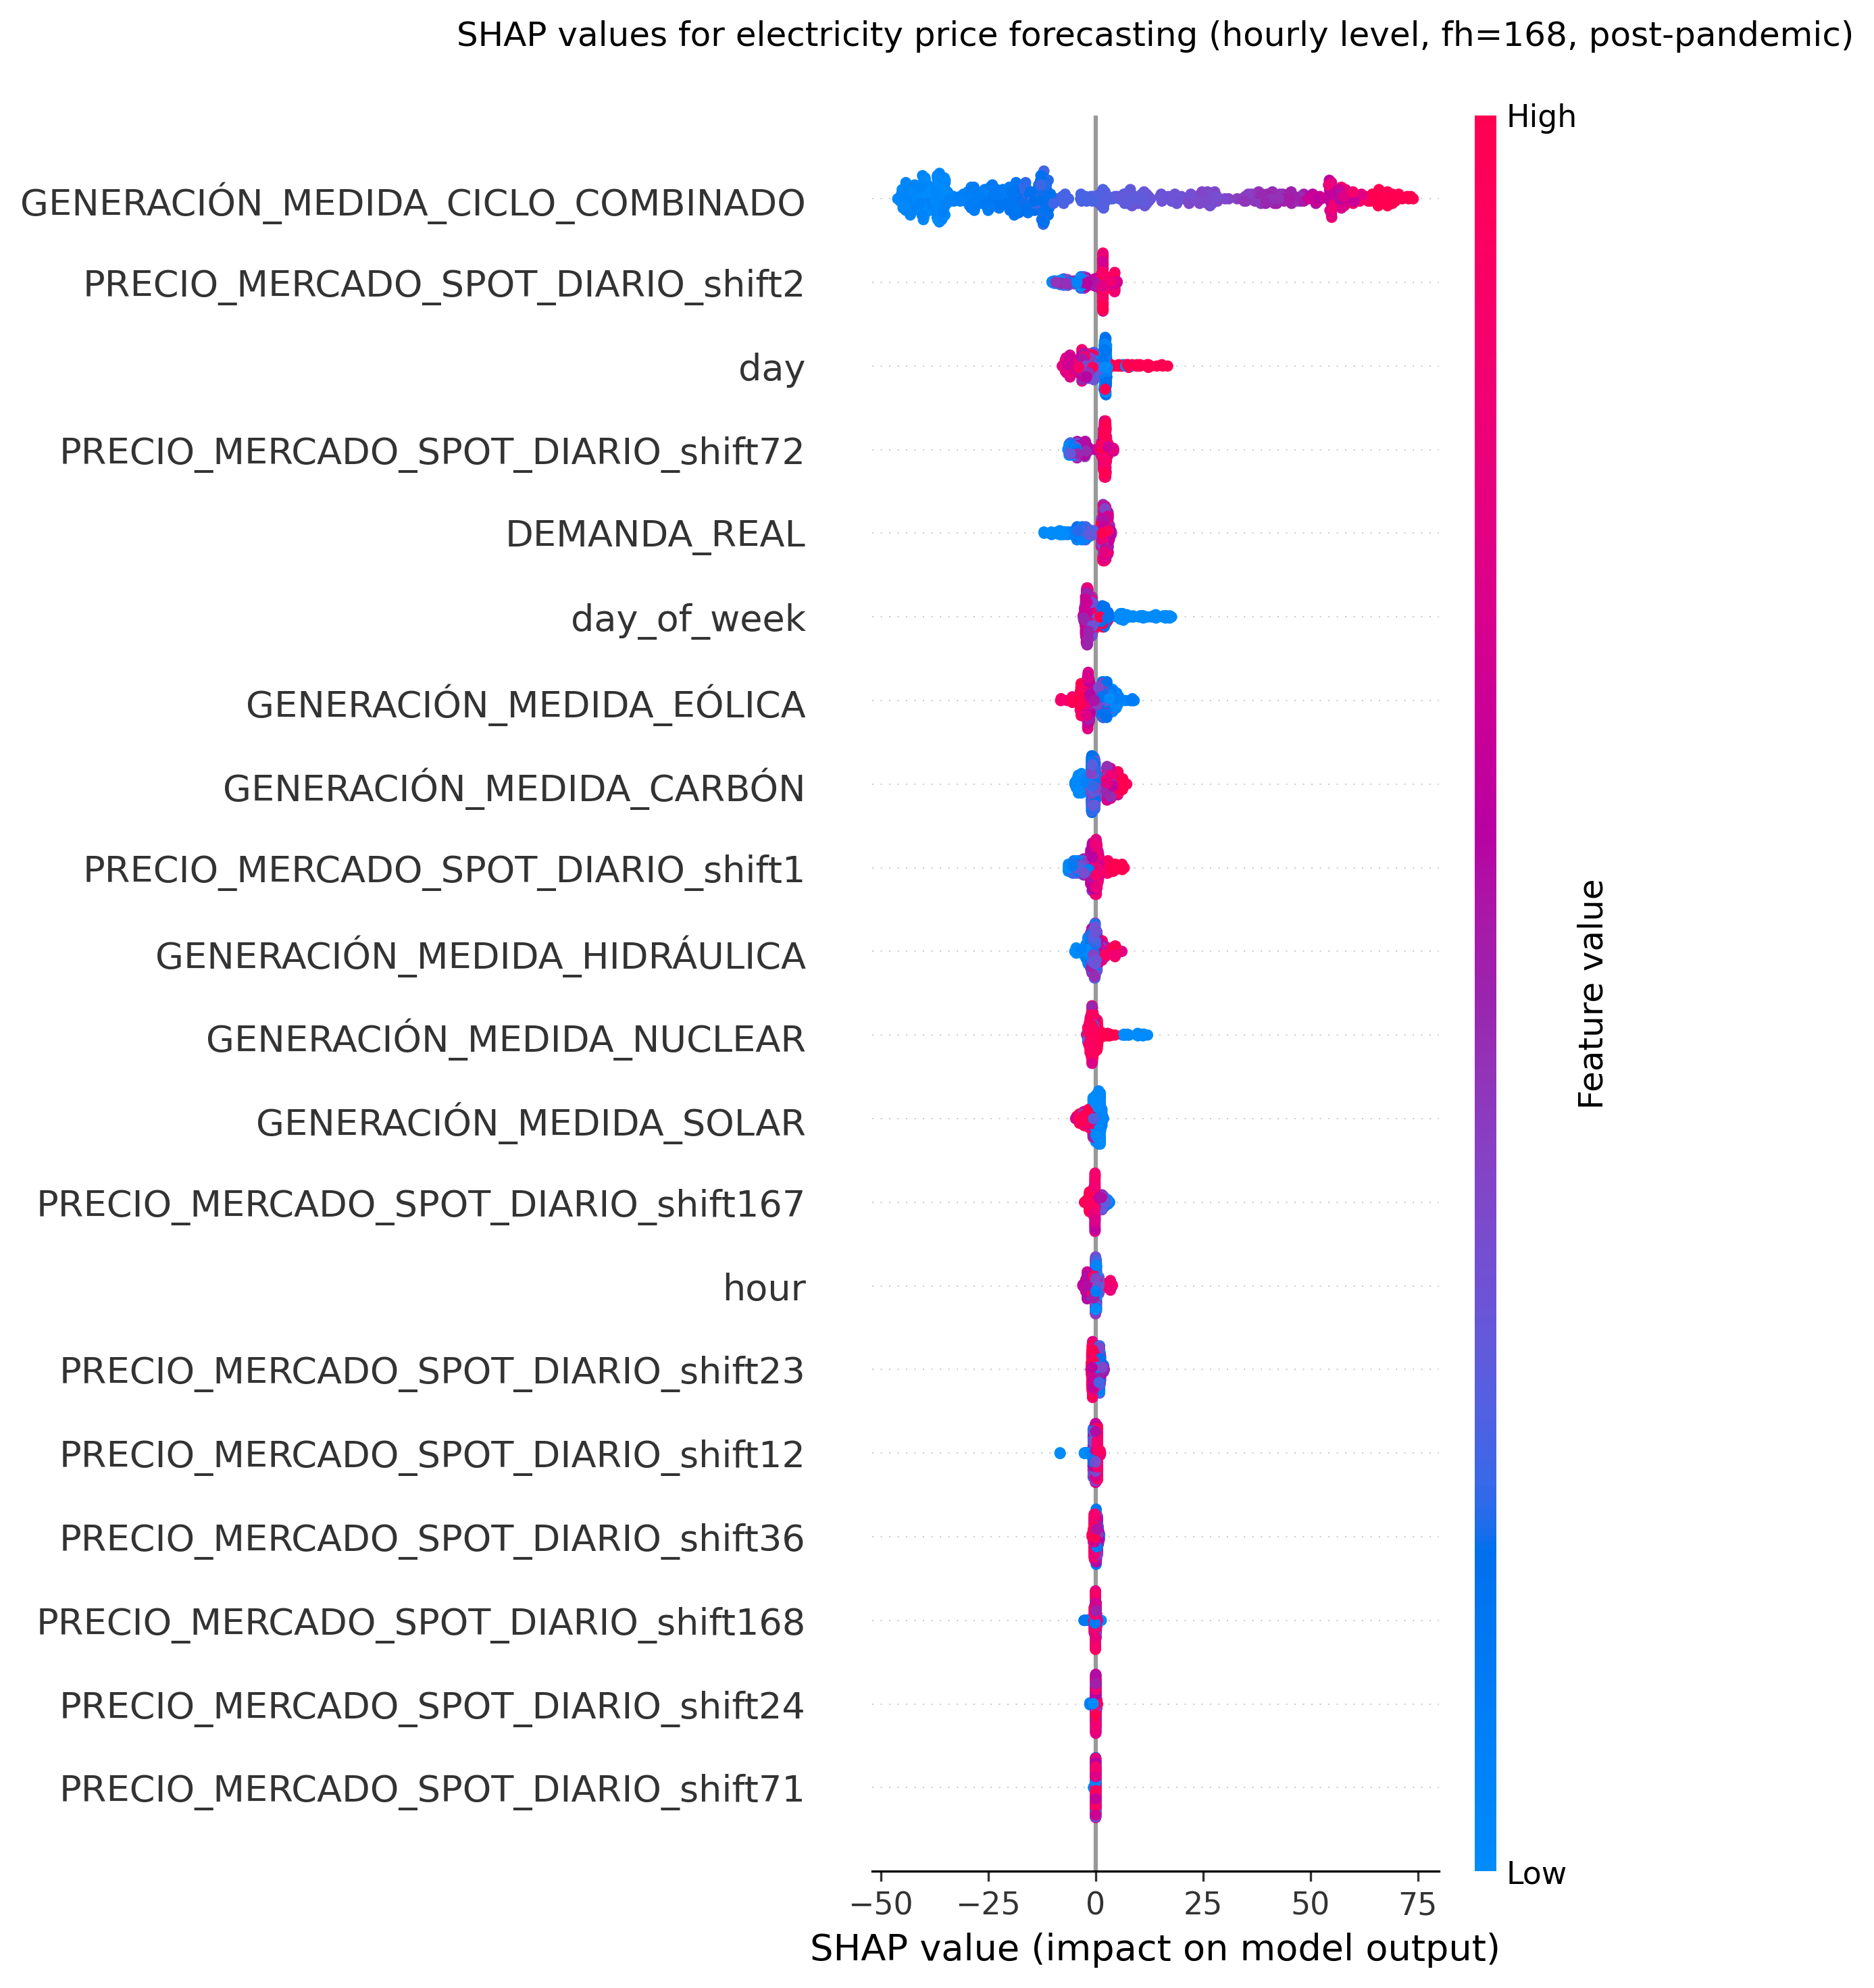

In [18]:
shap.summary_plot(shap_values_last_postpandemic, show=False)
plt.title("SHAP values for electricity price forecasting (hourly level, fh=168, post-pandemic)", y=1.03)
plt.show()

## Prepandemic

In [12]:
best_model = RandomForestRegressor(random_state=0)

In [13]:
esios_df = esios_provider.get_all_series(freq="H", start_index="2018-10-01 00:00", end_index="2019-03-31 23:59")

contamination = 0.01
esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

esios_spot = esios_df["PRECIO_MERCADO_SPOT_DIARIO"]
X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
lags = [1, 2, 12, 23, 24, 36, 71, 72, 167, 168]
date_features = ["hour", "day", "day_of_week"]

### 1 hour forecast horizon

In [14]:
shap_values_first_prepandemic = func.predictors_influence_study(esios_spot, X, best_model, lags, date_features, forecasting_horizon, version="first", seed=SEED)

Permutation explainer: 606it [04:19,  2.24it/s]                         


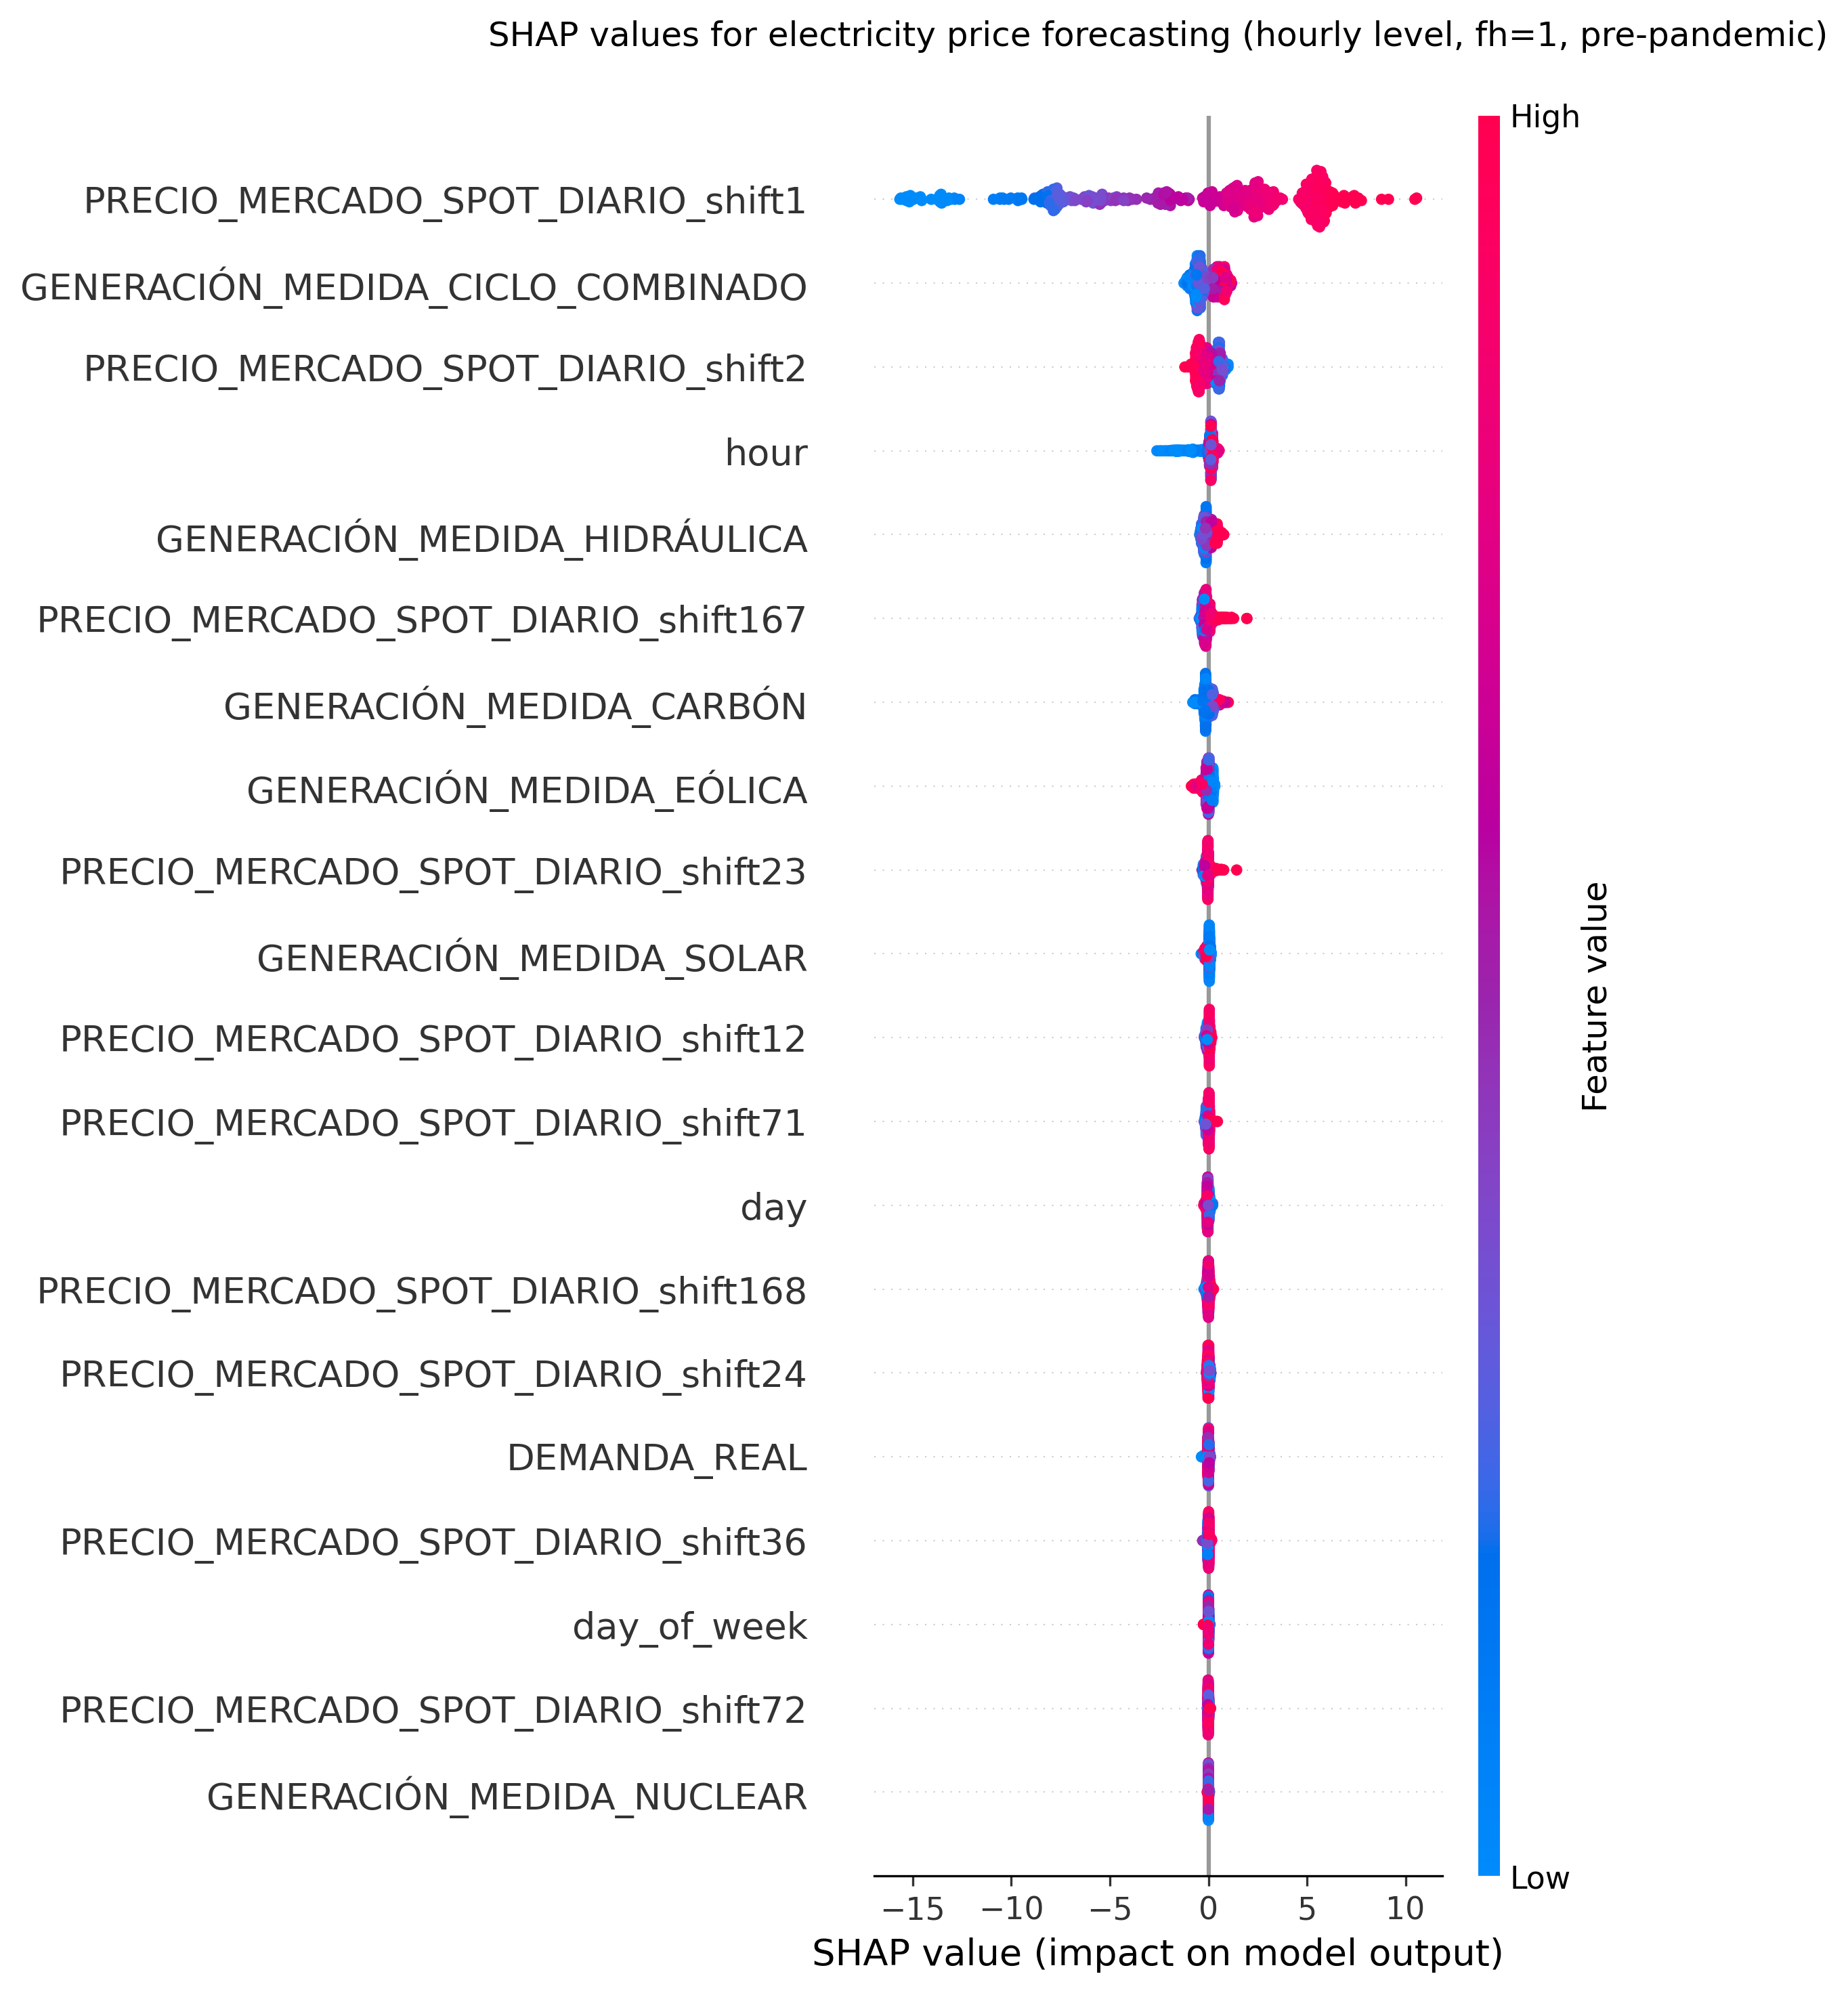

In [15]:
shap.summary_plot(shap_values_first_prepandemic, show=False)
plt.title("SHAP values for electricity price forecasting (hourly level, fh=1, pre-pandemic)", y=1.03)
plt.show()

### 168 hours forecast horizon

In [16]:
shap_values_last_prepandemic = func.predictors_influence_study(esios_spot, X, best_model, lags, date_features, forecasting_horizon, version="last", seed=SEED)

Permutation explainer: 606it [03:51,  2.51it/s]                         


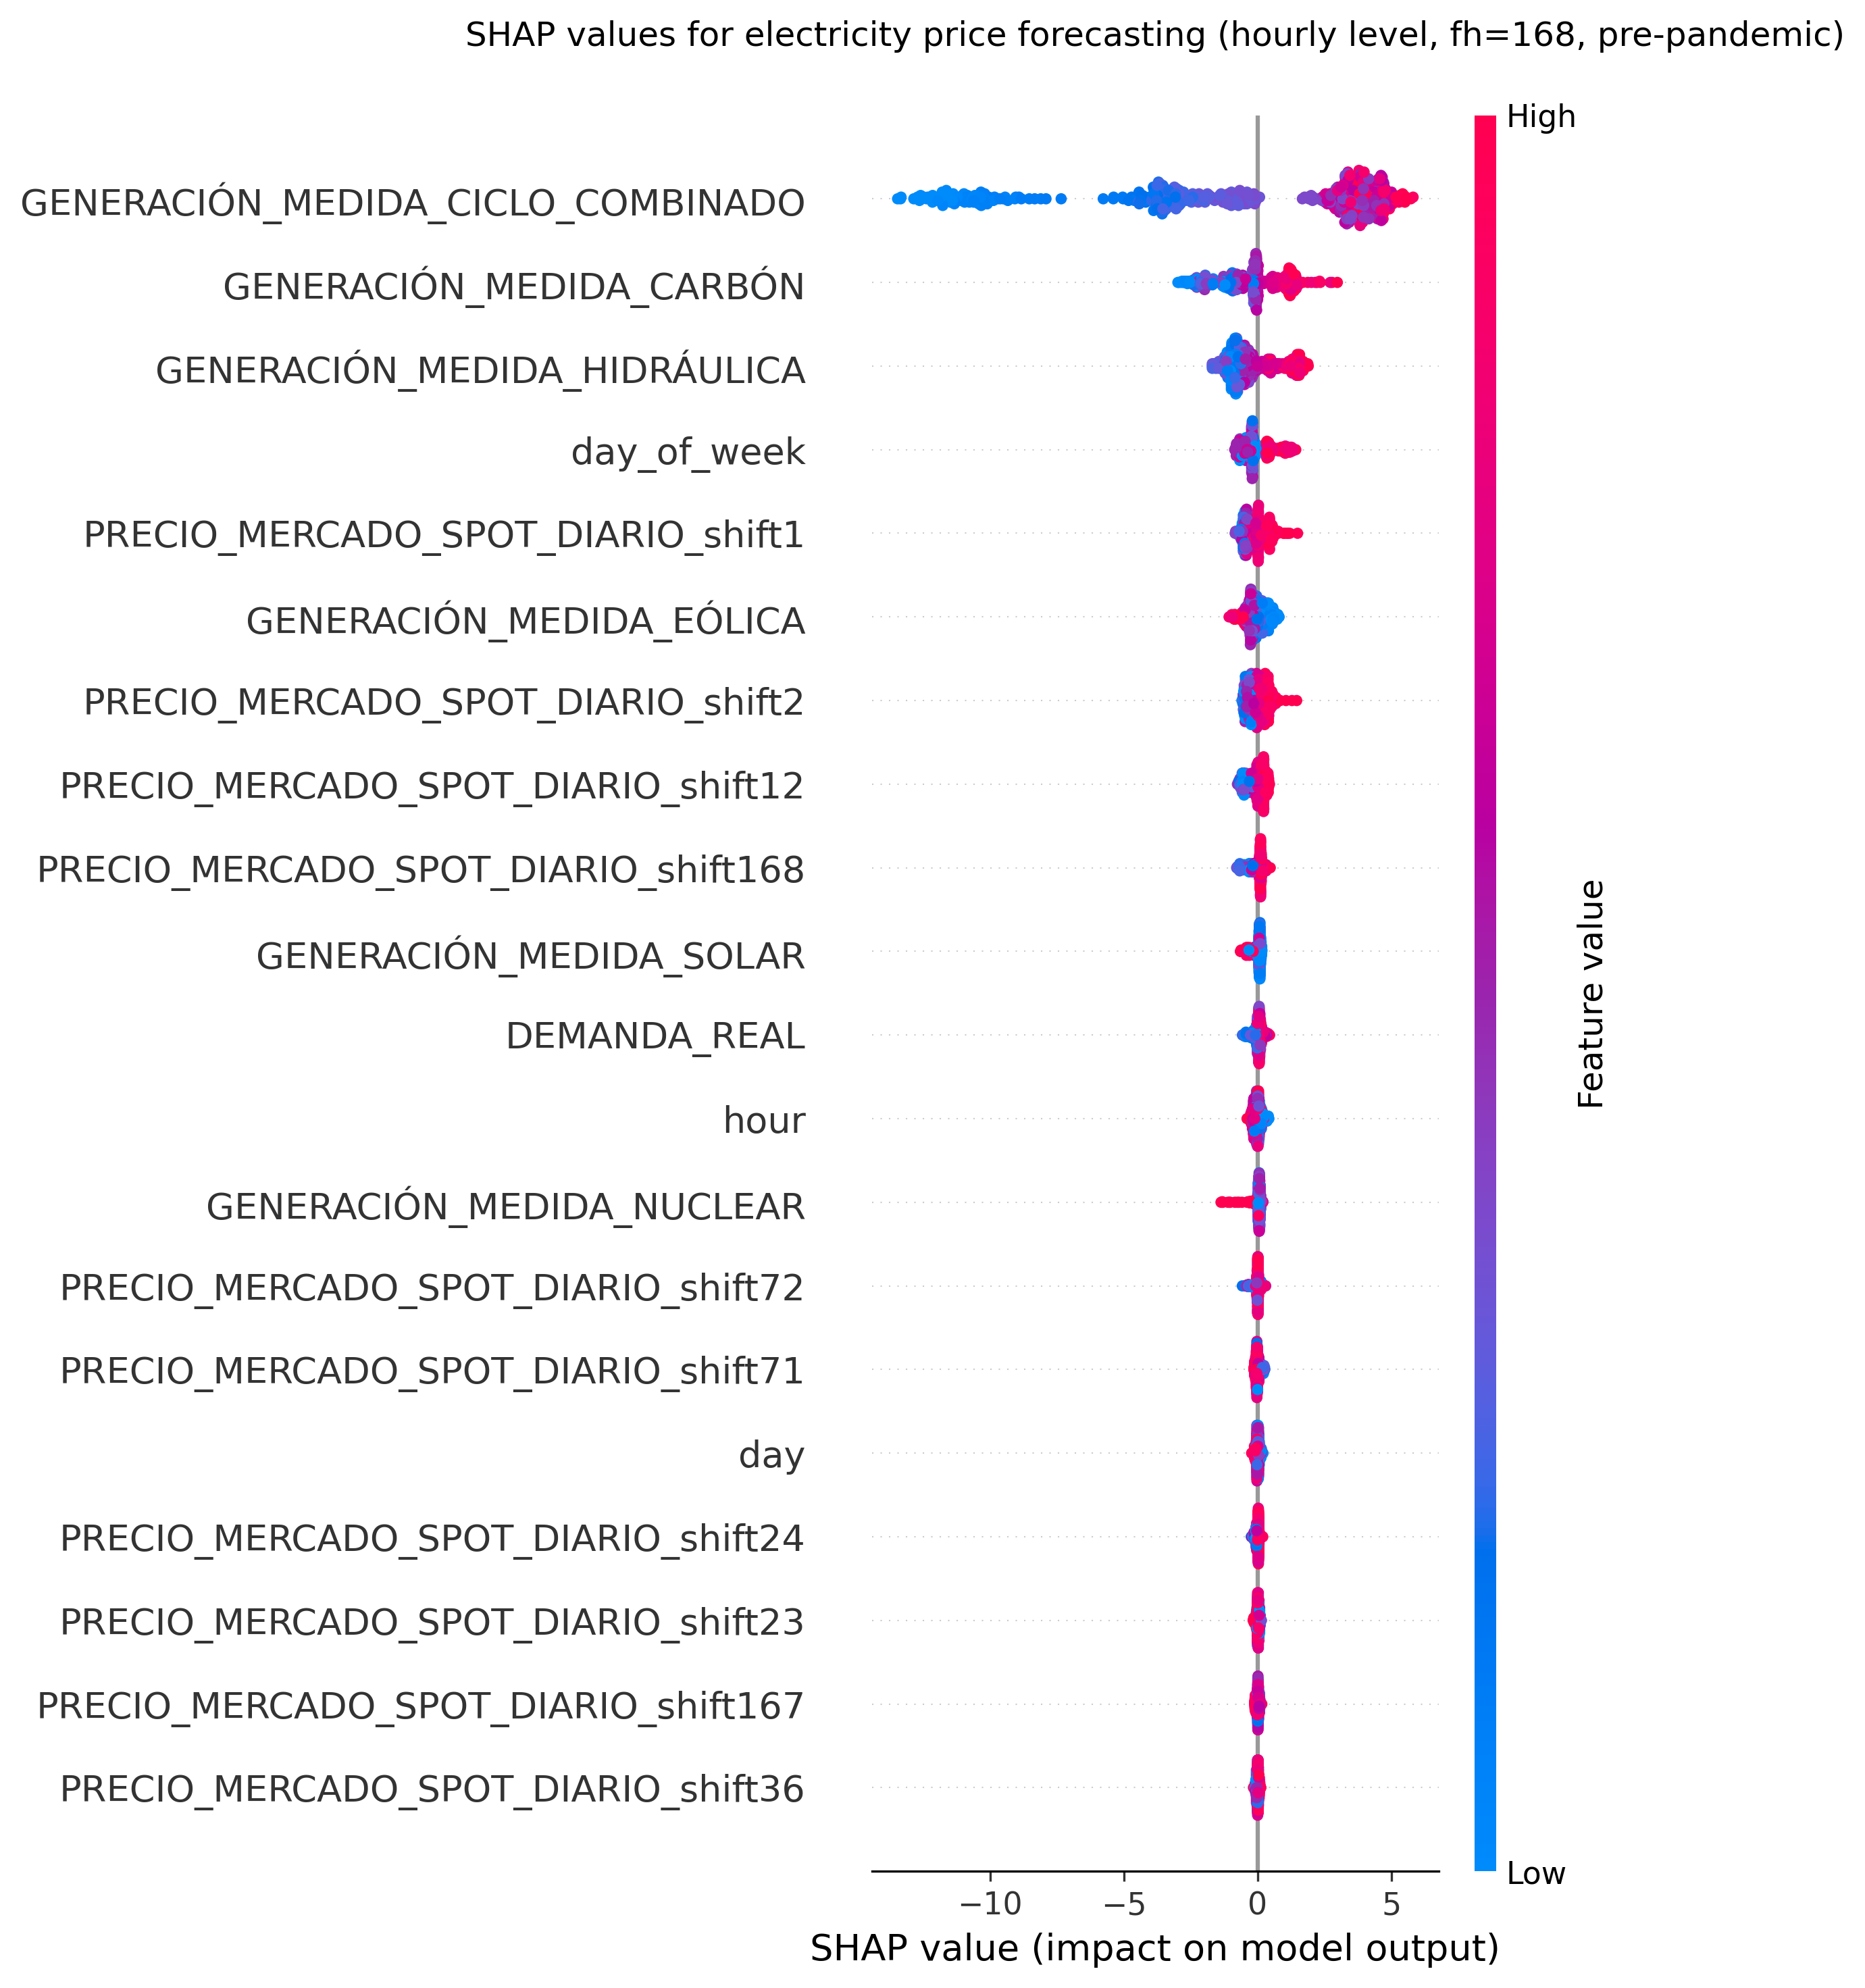

In [17]:
shap.summary_plot(shap_values_last_prepandemic, show=False)
plt.title("SHAP values for electricity price forecasting (hourly level, fh=168, pre-pandemic)", y=1.03)
plt.show()